In [6]:
import pandas as pd
import numpy as np
import pymc3 as pm
import graphviz
import arviz as az
import seaborn as sns

In [8]:
df = pd.read_csv('pres-data.csv', index_col=0).reset_index().query("year < 2021")
df = df.rename({
    'Housing Inventory: Median Listing Price':'med_housing',
    'Unemployment Rate':'unemployment',
    'All Employees: Federal Government	Housing Inventory: Median Home Size in ':'govt_employees',
    'Housing Inventory: Median Days on Market':'housing_mkt_days',
    'Housing Inventory: New Listing Count':'housing_listings',
    'All Employees: Financial Activities':'financial_act',
    'All Employees: Education and Health Services':'educ_health',
    'All Employees: Federal Government':'fed_employees',
    'Resident Population':'population',
    'Per Capita Personal Income':'income',
    'Housing Inventory: Median Home Size in Square Feet':'home_size'
}, axis=1)

df.insert(0, 'year_month', df.year + df.month/100)

df = df.drop(columns=[
        'financial_act',
        'fed_employees',
        'educ_health',
        'home_size',
        'housing_mkt_days'
])

df

,year_month,year,month,city,state,med_housing,unemployment,housing_listings,population,income
0,2016.07,2016,7,Atlanta,GA,272000.0,5.1,14848.0,5791.874,48657.0
1,2016.08,2016,8,Atlanta,GA,269900.0,5.1,13340.0,5791.874,48657.0
2,2016.09,2016,9,Atlanta,GA,270168.0,5.1,13404.0,5791.874,48657.0
3,2016.10,2016,10,Atlanta,GA,269900.0,5.1,12996.0,5791.874,48657.0
4,2016.11,2016,11,Atlanta,GA,269900.0,5.1,10848.0,5791.874,48657.0
...,...,...,...,...,...,...,...,...,...,...
244,2020.08,2020,8,Tulsa,OK,282000.0,6.6,1112.0,1006.411,58071.0
245,2020.09,2020,9,Tulsa,OK,281250.0,6.0,1036.0,1006.411,58071.0
246,2020.10,2020,10,Tulsa,OK,275000.0,5.3,1048.0,1006.411,58071.0
247,2020.11,2020,11,Tulsa,OK,267450.0,5.1,992.0,1006.411,58071.0


In [9]:
order = 3

predictors=list(df.columns)[5:]

output='med_zhvi'
predictors

['med_housing', 'unemployment', 'housing_listings', 'population', 'income']

In [10]:
df.query("city=='Tulsa'").head(10)

,year_month,year,month,city,state,med_housing,unemployment,housing_listings,population,income
195,2016.07,2016,7,Tulsa,OK,207000.0,5.0,1468.0,989.124,48508.0
196,2016.08,2016,8,Tulsa,OK,207000.0,5.0,1448.0,989.124,48508.0
197,2016.09,2016,9,Tulsa,OK,199950.0,4.9,1376.0,989.124,48508.0
198,2016.10,2016,10,Tulsa,OK,197900.0,4.9,1316.0,989.124,48508.0
199,2016.11,2016,11,Tulsa,OK,195000.0,4.8,1240.0,989.124,48508.0
200,2016.12,2016,12,Tulsa,OK,192000.0,4.6,900.0,989.124,48508.0
201,2017.01,2017,1,Tulsa,OK,196500.0,4.5,1332.0,991.785,51778.0
202,2017.02,2017,2,Tulsa,OK,199949.5,4.4,1496.0,991.785,51778.0
203,2017.03,2017,3,Tulsa,OK,203768.5,4.4,1612.0,991.785,51778.0
204,2017.04,2017,4,Tulsa,OK,210000.0,4.3,1592.0,991.785,51778.0


We're doing modified autoregression because we're not estimating all of our predictors, we won't have a **prediction** past the next year unless we had a prediction for all of our predictors as well that we could feed back into the model. We'll either only be predicting for the next time slot or we'll have to come up with posterior models for each predictor to then feed back into the model. 

In [11]:
def generate_time_data(df, city, order, predictors):

  df = df.query(F"city== '{city}'").reset_index(drop=True)

  df_input = pd.DataFrame()

  year_months = []

  for period in range(order, len(df)):
    year_month = df.year_month.loc[period]
    # print(year_month)
    df2 = df.loc[period-order:period-1]
    # print(df2)

    df2['step'] = [i for i in range(order)]
    df_pivot = df2.pivot(index='city', columns='step', values=predictors).reset_index()
    df_pivot.columns = [col[0]+"_"+str(col[1]) for col in df_pivot.columns]
    # print(df_pivot)

    # Get relevant outputs
    query = F"year_month == {year_month}"
    for col in predictors:
      df_pivot[col] = df.query(query).reset_index(drop=True)[col].iloc[0]

    df_input = pd.concat([df_input, df_pivot])
    year_months.append(year_month)

  # print(df_input)

  df_input.insert(1, 'year_month',year_months)
  df_input = df_input.reset_index(drop=True)
  # df_input.columns=[str(col[0]) + str(col[1]) for col in df_input.columns.values]
  return df_input

generate_time_data(df=df, city='Tulsa',order=4, predictors = predictors).tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,city_,year_month,med_housing_0,med_housing_1,med_housing_2,med_housing_3,unemployment_0,unemployment_1,unemployment_2,unemployment_3,housing_listings_0,housing_listings_1,housing_listings_2,housing_listings_3,population_0,population_1,population_2,population_3,income_0,income_1,income_2,income_3,med_housing,unemployment,housing_listings,population,income
40,Tulsa,2020.03,248500.0,249725.0,239900.0,245000.0,3.0,3.0,3.0,3.1,908.0,900.0,1048.0,1120.0,999.348,999.348,1006.411,1006.411,56680.0,56680.0,58071.0,58071.0,256000.0,3.3,1232.0,1006.411,58071.0
41,Tulsa,2020.04,249725.0,239900.0,245000.0,256000.0,3.0,3.0,3.1,3.3,900.0,1048.0,1120.0,1232.0,999.348,1006.411,1006.411,1006.411,56680.0,58071.0,58071.0,58071.0,261700.0,13.7,1048.0,1006.411,58071.0
42,Tulsa,2020.05,239900.0,245000.0,256000.0,261700.0,3.0,3.1,3.3,13.7,1048.0,1120.0,1232.0,1048.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,269500.0,10.1,1124.0,1006.411,58071.0
43,Tulsa,2020.06,245000.0,256000.0,261700.0,269500.0,3.1,3.3,13.7,10.1,1120.0,1232.0,1048.0,1124.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,282450.0,8.5,1132.0,1006.411,58071.0
44,Tulsa,2020.07,256000.0,261700.0,269500.0,282450.0,3.3,13.7,10.1,8.5,1232.0,1048.0,1124.0,1132.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,293750.0,7.7,1164.0,1006.411,58071.0
45,Tulsa,2020.08,261700.0,269500.0,282450.0,293750.0,13.7,10.1,8.5,7.7,1048.0,1124.0,1132.0,1164.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,282000.0,6.6,1112.0,1006.411,58071.0
46,Tulsa,2020.09,269500.0,282450.0,293750.0,282000.0,10.1,8.5,7.7,6.6,1124.0,1132.0,1164.0,1112.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,281250.0,6.0,1036.0,1006.411,58071.0
47,Tulsa,2020.10,282450.0,293750.0,282000.0,281250.0,8.5,7.7,6.6,6.0,1132.0,1164.0,1112.0,1036.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,275000.0,5.3,1048.0,1006.411,58071.0
48,Tulsa,2020.11,293750.0,282000.0,281250.0,275000.0,7.7,6.6,6.0,5.3,1164.0,1112.0,1036.0,1048.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,267450.0,5.1,992.0,1006.411,58071.0
49,Tulsa,2020.12,282000.0,281250.0,275000.0,267450.0,6.6,6.0,5.3,5.1,1112.0,1036.0,1048.0,992.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,270512.0,4.9,652.0,1006.411,58071.0


## Format Data for model input

In [12]:
input = generate_time_data(df=df, city='Tulsa',order=2, predictors = predictors)
input.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,city_,year_month,med_housing_0,med_housing_1,unemployment_0,unemployment_1,housing_listings_0,housing_listings_1,population_0,population_1,income_0,income_1,med_housing,unemployment,housing_listings,population,income
0,Tulsa,2016.09,207000.0,207000.0,5.0,5.0,1468.0,1448.0,989.124,989.124,48508.0,48508.0,199950.0,4.9,1376.0,989.124,48508.0
1,Tulsa,2016.10,207000.0,199950.0,5.0,4.9,1448.0,1376.0,989.124,989.124,48508.0,48508.0,197900.0,4.9,1316.0,989.124,48508.0
2,Tulsa,2016.11,199950.0,197900.0,4.9,4.9,1376.0,1316.0,989.124,989.124,48508.0,48508.0,195000.0,4.8,1240.0,989.124,48508.0
3,Tulsa,2016.12,197900.0,195000.0,4.9,4.8,1316.0,1240.0,989.124,989.124,48508.0,48508.0,192000.0,4.6,900.0,989.124,48508.0
4,Tulsa,2017.01,195000.0,192000.0,4.8,4.6,1240.0,900.0,989.124,989.124,48508.0,48508.0,196500.0,4.5,1332.0,991.785,51778.0


In [13]:
nums = ['0','1','2','3','4','5','6','7','8','9']
columns = [col for col in input.columns if col[-1] in nums]
outputs = [col for col in input.columns[2:] if col[-1] not in nums]

for output in outputs:
  print(F"\t# {output}")
  input_names = []
  for col in columns:
    input_names.append(F"{col}_{output}")
    print(F"\t{col}_{output} = pm.Normal(name='{col}_{output}', mu=0, sigma=sig)")
    # print("")
  print("")
  print(F"\ttheta_{output} = (")  
  for name in columns:
    if name == columns[-1]:
      print(F"\t\t{name}_{output}*input.{name}")
    else:   
      print(F"\t\t{name}_{output}*input.{name}+")
  print("\t)")

  print(F"\t{output} = pm.Normal('{output}', theta_{output}, sd=200, observed=input.{output})")

  print("")


	# med_housing
	med_housing_0_med_housing = pm.Normal(name='med_housing_0_med_housing', mu=0, sigma=sig)
	med_housing_1_med_housing = pm.Normal(name='med_housing_1_med_housing', mu=0, sigma=sig)
	unemployment_0_med_housing = pm.Normal(name='unemployment_0_med_housing', mu=0, sigma=sig)
	unemployment_1_med_housing = pm.Normal(name='unemployment_1_med_housing', mu=0, sigma=sig)
	housing_listings_0_med_housing = pm.Normal(name='housing_listings_0_med_housing', mu=0, sigma=sig)
	housing_listings_1_med_housing = pm.Normal(name='housing_listings_1_med_housing', mu=0, sigma=sig)
	population_0_med_housing = pm.Normal(name='population_0_med_housing', mu=0, sigma=sig)
	population_1_med_housing = pm.Normal(name='population_1_med_housing', mu=0, sigma=sig)
	income_0_med_housing = pm.Normal(name='income_0_med_housing', mu=0, sigma=sig)
	income_1_med_housing = pm.Normal(name='income_1_med_housing', mu=0, sigma=sig)

	theta_med_housing = (
		med_housing_0_med_housing*input.med_housing_0+
		med_housin

# Attempting a combined model for VAR

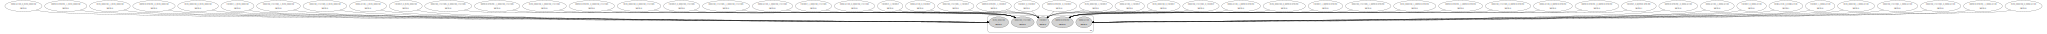

In [14]:
sig = 1000
with pm.Model() as model_comb:
	# med_housing
	med_housing_0_med_housing = pm.Normal(name='med_housing_0_med_housing', mu=0, sigma=sig)
	med_housing_1_med_housing = pm.Normal(name='med_housing_1_med_housing', mu=0, sigma=sig)
	unemployment_0_med_housing = pm.Normal(name='unemployment_0_med_housing', mu=0, sigma=sig)
	unemployment_1_med_housing = pm.Normal(name='unemployment_1_med_housing', mu=0, sigma=sig)
	housing_listings_0_med_housing = pm.Normal(name='housing_listings_0_med_housing', mu=0, sigma=sig)
	housing_listings_1_med_housing = pm.Normal(name='housing_listings_1_med_housing', mu=0, sigma=sig)
	population_0_med_housing = pm.Normal(name='population_0_med_housing', mu=0, sigma=sig)
	population_1_med_housing = pm.Normal(name='population_1_med_housing', mu=0, sigma=sig)
	income_0_med_housing = pm.Normal(name='income_0_med_housing', mu=0, sigma=sig)
	income_1_med_housing = pm.Normal(name='income_1_med_housing', mu=0, sigma=sig)

	theta_med_housing = (
		med_housing_0_med_housing*input.med_housing_0+
		med_housing_1_med_housing*input.med_housing_1+
		unemployment_0_med_housing*input.unemployment_0+
		unemployment_1_med_housing*input.unemployment_1+
		housing_listings_0_med_housing*input.housing_listings_0+
		housing_listings_1_med_housing*input.housing_listings_1+
		population_0_med_housing*input.population_0+
		population_1_med_housing*input.population_1+
		income_0_med_housing*input.income_0+
		income_1_med_housing*input.income_1
	)
	med_housing = pm.Normal('med_housing', theta_med_housing, sd=200, observed=input.med_housing)

	# unemployment
	med_housing_0_unemployment = pm.Normal(name='med_housing_0_unemployment', mu=0, sigma=sig)
	med_housing_1_unemployment = pm.Normal(name='med_housing_1_unemployment', mu=0, sigma=sig)
	unemployment_0_unemployment = pm.Normal(name='unemployment_0_unemployment', mu=0, sigma=sig)
	unemployment_1_unemployment = pm.Normal(name='unemployment_1_unemployment', mu=0, sigma=sig)
	housing_listings_0_unemployment = pm.Normal(name='housing_listings_0_unemployment', mu=0, sigma=sig)
	housing_listings_1_unemployment = pm.Normal(name='housing_listings_1_unemployment', mu=0, sigma=sig)
	population_0_unemployment = pm.Normal(name='population_0_unemployment', mu=0, sigma=sig)
	population_1_unemployment = pm.Normal(name='population_1_unemployment', mu=0, sigma=sig)
	income_0_unemployment = pm.Normal(name='income_0_unemployment', mu=0, sigma=sig)
	income_1_unemployment = pm.Normal(name='income_1_unemployment', mu=0, sigma=sig)

	theta_unemployment = (
		med_housing_0_unemployment*input.med_housing_0+
		med_housing_1_unemployment*input.med_housing_1+
		unemployment_0_unemployment*input.unemployment_0+
		unemployment_1_unemployment*input.unemployment_1+
		housing_listings_0_unemployment*input.housing_listings_0+
		housing_listings_1_unemployment*input.housing_listings_1+
		population_0_unemployment*input.population_0+
		population_1_unemployment*input.population_1+
		income_0_unemployment*input.income_0+
		income_1_unemployment*input.income_1
	)
	unemployment = pm.Normal('unemployment', theta_unemployment, sd=200, observed=input.unemployment)

	# housing_listings
	med_housing_0_housing_listings = pm.Normal(name='med_housing_0_housing_listings', mu=0, sigma=sig)
	med_housing_1_housing_listings = pm.Normal(name='med_housing_1_housing_listings', mu=0, sigma=sig)
	unemployment_0_housing_listings = pm.Normal(name='unemployment_0_housing_listings', mu=0, sigma=sig)
	unemployment_1_housing_listings = pm.Normal(name='unemployment_1_housing_listings', mu=0, sigma=sig)
	housing_listings_0_housing_listings = pm.Normal(name='housing_listings_0_housing_listings', mu=0, sigma=sig)
	housing_listings_1_housing_listings = pm.Normal(name='housing_listings_1_housing_listings', mu=0, sigma=sig)
	population_0_housing_listings = pm.Normal(name='population_0_housing_listings', mu=0, sigma=sig)
	population_1_housing_listings = pm.Normal(name='population_1_housing_listings', mu=0, sigma=sig)
	income_0_housing_listings = pm.Normal(name='income_0_housing_listings', mu=0, sigma=sig)
	income_1_housing_listings = pm.Normal(name='income_1_housing_listings', mu=0, sigma=sig)

	theta_housing_listings = (
		med_housing_0_housing_listings*input.med_housing_0+
		med_housing_1_housing_listings*input.med_housing_1+
		unemployment_0_housing_listings*input.unemployment_0+
		unemployment_1_housing_listings*input.unemployment_1+
		housing_listings_0_housing_listings*input.housing_listings_0+
		housing_listings_1_housing_listings*input.housing_listings_1+
		population_0_housing_listings*input.population_0+
		population_1_housing_listings*input.population_1+
		income_0_housing_listings*input.income_0+
		income_1_housing_listings*input.income_1
	)
	housing_listings = pm.Normal('housing_listings', theta_housing_listings, sd=200, observed=input.housing_listings)

	# population
	med_housing_0_population = pm.Normal(name='med_housing_0_population', mu=0, sigma=sig)
	med_housing_1_population = pm.Normal(name='med_housing_1_population', mu=0, sigma=sig)
	unemployment_0_population = pm.Normal(name='unemployment_0_population', mu=0, sigma=sig)
	unemployment_1_population = pm.Normal(name='unemployment_1_population', mu=0, sigma=sig)
	housing_listings_0_population = pm.Normal(name='housing_listings_0_population', mu=0, sigma=sig)
	housing_listings_1_population = pm.Normal(name='housing_listings_1_population', mu=0, sigma=sig)
	population_0_population = pm.Normal(name='population_0_population', mu=0, sigma=sig)
	population_1_population = pm.Normal(name='population_1_population', mu=0, sigma=sig)
	income_0_population = pm.Normal(name='income_0_population', mu=0, sigma=sig)
	income_1_population = pm.Normal(name='income_1_population', mu=0, sigma=sig)

	theta_population = (
		med_housing_0_population*input.med_housing_0+
		med_housing_1_population*input.med_housing_1+
		unemployment_0_population*input.unemployment_0+
		unemployment_1_population*input.unemployment_1+
		housing_listings_0_population*input.housing_listings_0+
		housing_listings_1_population*input.housing_listings_1+
		population_0_population*input.population_0+
		population_1_population*input.population_1+
		income_0_population*input.income_0+
		income_1_population*input.income_1
	)
	population = pm.Normal('population', theta_population, sd=200, observed=input.population)

	# income
	med_housing_0_income = pm.Normal(name='med_housing_0_income', mu=0, sigma=sig)
	med_housing_1_income = pm.Normal(name='med_housing_1_income', mu=0, sigma=sig)
	unemployment_0_income = pm.Normal(name='unemployment_0_income', mu=0, sigma=sig)
	unemployment_1_income = pm.Normal(name='unemployment_1_income', mu=0, sigma=sig)
	housing_listings_0_income = pm.Normal(name='housing_listings_0_income', mu=0, sigma=sig)
	housing_listings_1_income = pm.Normal(name='housing_listings_1_income', mu=0, sigma=sig)
	population_0_income = pm.Normal(name='population_0_income', mu=0, sigma=sig)
	population_1_income = pm.Normal(name='population_1_income', mu=0, sigma=sig)
	income_0_income = pm.Normal(name='income_0_income', mu=0, sigma=sig)
	income_1_income = pm.Normal(name='income_1_income', mu=0, sigma=sig)

	theta_income = (
		med_housing_0_income*input.med_housing_0+
		med_housing_1_income*input.med_housing_1+
		unemployment_0_income*input.unemployment_0+
		unemployment_1_income*input.unemployment_1+
		housing_listings_0_income*input.housing_listings_0+
		housing_listings_1_income*input.housing_listings_1+
		population_0_income*input.population_0+
		population_1_income*input.population_1+
		income_0_income*input.income_0+
		income_1_income*input.income_1
	)
	income = pm.Normal('income', theta_income, sd=200, observed=input.income)
pm.model_to_graphviz(model_comb)

In [15]:
# with model_comb:
#     comb_trace = pm.sample(100)
#     comb_idata = az.from_pymc3(comb_trace)
# post_parameters = az.summary(comb_idata, round_to=2)
# post_parameters

In [16]:
SEED = 12345
np.random.seed(SEED)

# Obtain the variational approximation to the beta
with model_comb:
  approx = pm.fit(50000, method = 'advi', random_seed = SEED)
advi = approx.sample(50000)

Finished [100%]: Average Loss = 25,784


In [17]:
print(advi.varnames)

values = advi.varnames
means = []
stds = []

for value in advi.varnames:
  means.append(round(np.mean(advi.get_values(value)),3))
  stds.append(round(np.std(advi.get_values(value)),5))

parameters = pd.DataFrame({
    'variable':values,
    'mean':means,
    'std':stds
})

parameters


['med_housing_0_med_housing', 'med_housing_1_med_housing', 'unemployment_0_med_housing', 'unemployment_1_med_housing', 'housing_listings_0_med_housing', 'housing_listings_1_med_housing', 'population_0_med_housing', 'population_1_med_housing', 'income_0_med_housing', 'income_1_med_housing', 'med_housing_0_unemployment', 'med_housing_1_unemployment', 'unemployment_0_unemployment', 'unemployment_1_unemployment', 'housing_listings_0_unemployment', 'housing_listings_1_unemployment', 'population_0_unemployment', 'population_1_unemployment', 'income_0_unemployment', 'income_1_unemployment', 'med_housing_0_housing_listings', 'med_housing_1_housing_listings', 'unemployment_0_housing_listings', 'unemployment_1_housing_listings', 'housing_listings_0_housing_listings', 'housing_listings_1_housing_listings', 'population_0_housing_listings', 'population_1_housing_listings', 'income_0_housing_listings', 'income_1_housing_listings', 'med_housing_0_population', 'med_housing_1_population', 'unemployment

,variable,mean,std
0,med_housing_0_med_housing,0.265,0.00103
1,med_housing_1_med_housing,0.641,0.00107
2,unemployment_0_med_housing,3.296,1.23640
3,unemployment_1_med_housing,3.751,1.23831
4,housing_listings_0_med_housing,-1.426,0.15629
5,housing_listings_1_med_housing,-0.658,0.15471
6,population_0_med_housing,-0.302,0.18926
7,population_1_med_housing,-0.300,0.19610
8,income_0_med_housing,0.240,0.00456
9,income_1_med_housing,0.246,0.00464


### Generate predictions

# Idea: Generate predictions via manual sampling from the posterior parameters

In [18]:
def get_initial_prediction(input, year_month, order):

  new_df = input.query(F"year_month == {year_month}").reset_index(drop=True)

  city = new_df['city_'].loc[0]
  build_df = pd.Series()

  for col in outputs:
    for i in range(order,0,-1):

      # print(i)

      if i == order:
        new_col = F"{col}_{i-1}"
        build_df[new_col] = new_df[col].loc[0]
      else:
        new_col = F"{col}_{i-1}"
        build_df[new_col] = new_df[F"{col}_{i}"].loc[0]

  build_df = pd.DataFrame(build_df).transpose()
  build_df.insert(0, 'city_', city)
  build_df.insert(1, 'year_month', year_month)
  return build_df

get_initial_prediction(input=input, year_month=2020.12, order = 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,city_,year_month,med_housing_1,med_housing_0,unemployment_1,unemployment_0,housing_listings_1,housing_listings_0,population_1,population_0,income_1,income_0
0,Tulsa,2020.12,270512.0,267450.0,4.9,5.1,652.0,992.0,1006.411,1006.411,58071.0,58071.0


In [19]:
def get_initial_prediction(input, year_month, order):

  new_df = input.query(F"year_month == {year_month}").reset_index(drop=True)

  city = new_df['city_'].loc[0]
  build_df = pd.Series()

  for col in outputs:
    for i in range(order,0,-1):

      # print(i)

      if i == order:
        new_col = F"{col}_{i-1}"
        build_df[new_col] = new_df[col].loc[0]
      else:
        new_col = F"{col}_{i-1}"
        build_df[new_col] = new_df[F"{col}_{i}"].loc[0]

  build_df = pd.DataFrame(build_df).transpose()
  build_df.insert(0, 'city_', city)
  build_df.insert(1, 'year_month', year_month)
  return build_df

df_pred = get_initial_prediction(input=input, year_month=2020.12, order = 2)
df_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,city_,year_month,med_housing_1,med_housing_0,unemployment_1,unemployment_0,housing_listings_1,housing_listings_0,population_1,population_0,income_1,income_0
0,Tulsa,2020.12,270512.0,267450.0,4.9,5.1,652.0,992.0,1006.411,1006.411,58071.0,58071.0


In [20]:
parameters

,variable,mean,std
0,med_housing_0_med_housing,0.265,0.00103
1,med_housing_1_med_housing,0.641,0.00107
2,unemployment_0_med_housing,3.296,1.23640
3,unemployment_1_med_housing,3.751,1.23831
4,housing_listings_0_med_housing,-1.426,0.15629
5,housing_listings_1_med_housing,-0.658,0.15471
6,population_0_med_housing,-0.302,0.18926
7,population_1_med_housing,-0.300,0.19610
8,income_0_med_housing,0.240,0.00456
9,income_1_med_housing,0.246,0.00464


In [21]:
outputs
print(list(parameters[parameters.variable.str.contains("_med_housing")].variable))
df_pred

['med_housing_0_med_housing', 'med_housing_1_med_housing', 'unemployment_0_med_housing', 'unemployment_1_med_housing', 'housing_listings_0_med_housing', 'housing_listings_1_med_housing', 'population_0_med_housing', 'population_1_med_housing', 'income_0_med_housing', 'income_1_med_housing']


,city_,year_month,med_housing_1,med_housing_0,unemployment_1,unemployment_0,housing_listings_1,housing_listings_0,population_1,population_0,income_1,income_0
0,Tulsa,2020.12,270512.0,267450.0,4.9,5.1,652.0,992.0,1006.411,1006.411,58071.0,58071.0


In [22]:
int(round(100*(2020.12 % 1),0))

12

In [23]:
samples = 10000
order = 2

def get_new_prediction(df_preds, samples, order, df_stdev=pd.DataFrame(), first=True):

  # print(df_preds)
  city = df_preds['city_'].iloc[-1]
  year_month = df_preds['year_month'].iloc[-1]

  month = int(round(100*(year_month % 1),0))
  # print(year_month)
  year = round(year_month, 0)
  if month == 12:
    month = 1
    year += 1
  else:
    month += 1

  # print(month)

  year_month = year + month/100

  df_new = pd.Series()
  df_std = pd.Series()

  for output in outputs:
    # print(output)
    param_list = list(parameters[parameters.variable.str.contains(F"_{output}")].variable)
    sample_array = np.zeros(samples)
    
    for param in param_list:
      
      num = int(param.split(F"_{output}")[0][-1])
      
      if num < order and num > 0:
        # print("Num", num)
        # print(F"{output}_{str(num)}")
        df_new[F"{output}_{str(num-1)}"] = df_preds[F"{output}_{str(num)}"].iloc[-1]
        # print(df_pred[F"{output}_{str(num)}"].iloc[-1])

      mean = parameters.query(F"variable == '{param}'")['mean'].reset_index(drop=True).loc[0]
      std = parameters.query(F"variable == '{param}'")['std'].reset_index(drop=True).loc[0]
      
      if first or param.split(F"_{output}")[0] not in df_stdev.columns:
        sample_array += np.random.normal(loc=mean, scale=std, size=samples) * df_preds[param.split(F"_{output}")[0]].iloc[-1]
      else:
        sample_array += np.random.normal(loc=mean, scale=std, size=samples) * np.random.normal(loc=df_preds[param.split(F"_{output}")[0]].iloc[-1], scale=df_stdev[param.split(F"_{output}")[0]].iloc[-1])

    new_average = round(np.mean(sample_array), 2)
    new_std = round(np.std(sample_array),2)

    df_new[F"{output}_{order-1}"] = new_average
    df_std[F"{output}_{order-1}"] = new_std

  df_new = pd.DataFrame(df_new).transpose()
  df_new.insert(0, 'city_', city)
  df_new.insert(1, 'year_month',year_month)
  df_new

  df_std = pd.DataFrame(df_std).transpose()
  df_std.insert(0, 'city_', city)
  df_std.insert(1, 'year_month',year_month)

  # print(list(df_stdev.columns[2:]))
  for col in list(df_stdev.columns[2:]):
    new_num = int(col[-1])-1
    if new_num >= 0:
      new_col = col.replace(col[-1], str(new_num))
      # print(df_stdev[col].iloc[-1])
      df_std[new_col] = df_stdev[col].iloc[-1]

  df_std
  return df_new, df_std

df_mean, df_std = get_new_prediction(df_preds=df_pred, samples=samples, order=order)
df_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,city_,year_month,med_housing_1,unemployment_1,housing_listings_1,population_1,income_1
0,Tulsa,2021.01,640.76,648.19,639.88,647.02,639.04


In [27]:
df_pred
samples = 10000
steps = 10

means, stds = get_new_prediction(df_preds=df_pred, samples=samples, first=True, order=order)

mean_df = pd.DataFrame()
std_df = pd.DataFrame()
for i in range(steps):
  means, stds = get_new_prediction(df_preds=means, samples=samples, first=False, df_stdev=stds, order=order)
  mean_df = pd.concat([mean_df, means]).reset_index(drop=True)
  std_df = pd.concat([std_df, stds]).reset_index(drop=True)

mean_df
std_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,city_,year_month,med_housing_1,unemployment_1,housing_listings_1,population_1,income_1,med_housing_0,unemployment_0,housing_listings_0,population_0,income_0
0,Tulsa,2021.02,928.71,676.27,731.09,738.93,651.85,641.85,647.81,637.99,652.28,636.09
1,Tulsa,2021.03,631.79,968.69,1676.80,917.17,1601.00,928.71,676.27,731.09,738.93,651.85
2,Tulsa,2021.04,2036.60,2195.81,1177.52,1921.40,1758.96,631.79,968.69,1676.80,917.17,1601.00
3,Tulsa,2021.05,1622.06,5275.31,4088.56,3131.75,853.14,2036.60,2195.81,1177.52,1921.40,1758.96
4,Tulsa,2021.06,5157.22,5348.77,4401.11,4274.43,5793.74,1622.06,5275.31,4088.56,3131.75,853.14
5,Tulsa,2021.07,5299.76,7330.79,2146.81,12541.49,3486.38,5157.22,5348.77,4401.11,4274.43,5793.74
6,Tulsa,2021.08,13301.56,7118.18,6543.01,13105.58,15360.43,5299.76,7330.79,2146.81,12541.49,3486.38
7,Tulsa,2021.09,14622.15,7072.37,21947.88,4569.63,15150.81,13301.56,7118.18,6543.01,13105.58,15360.43
8,Tulsa,2021.10,5218.61,12591.01,16897.70,20924.34,15740.05,14622.15,7072.37,21947.88,4569.63,15150.81
9,Tulsa,2021.11,13168.81,20047.26,28738.41,3011.96,44278.74,5218.61,12591.01,16897.70,20924.34,15740.05


# Visualize

In [29]:
mean_df

,city_,year_month,med_housing_0,med_housing_1,unemployment_0,unemployment_1,housing_listings_0,housing_listings_1,population_0,population_1,income_0,income_1
0,Tulsa,2021.02,270066.10,272989.45,-7.16,-0.88,904.59,949.73,803.75,813.85,58104.19,56905.59
1,Tulsa,2021.03,272989.45,273226.48,-0.88,4.48,949.73,490.50,813.85,790.25,56905.59,57691.72
2,Tulsa,2021.04,273226.48,267783.99,4.48,-12.50,490.50,833.91,790.25,739.15,57691.72,56039.26
3,Tulsa,2021.05,267783.99,275048.77,-12.50,42.39,833.91,709.78,739.15,703.43,56039.26,53549.46
4,Tulsa,2021.06,275048.77,261181.26,42.39,-26.38,709.78,1671.80,703.43,707.75,53549.46,55227.74
5,Tulsa,2021.07,261181.26,247080.38,-26.38,11.36,1671.80,1413.26,707.75,899.73,55227.74,62526.34
6,Tulsa,2021.08,247080.38,314908.27,11.36,102.11,1413.26,1101.94,899.73,-36.15,62526.34,44226.38
7,Tulsa,2021.09,314908.27,318366.92,102.11,4.88,1101.94,-6.58,-36.15,1078.95,44226.38,58483.33
8,Tulsa,2021.10,318366.92,322789.28,4.88,-10.43,-6.58,2547.95,1078.95,914.45,58483.33,85273.29
9,Tulsa,2021.11,322789.28,310128.18,-10.43,-126.79,2547.95,925.84,914.45,481.92,85273.29,71333.89


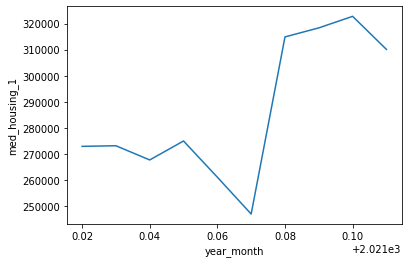

In [32]:
sns.lineplot(data=mean_df, x='year_month', y='med_housing_1')

### Test out multiple iterations

In [ ]:
temp, stds = get_predictions(df=cville, year=2020, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2)

new_pred, new_std = get_predictions(df=temp, year=2021, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2, first=False, df_std=stds)

pred3, std3 = get_predictions(df=new_pred, year=2022, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2, first=False, df_std=new_std)
pred3

In [ ]:
new_std

* Build out posterior predictive sampling
* Process to feed posterior prediction back into autoregression
* Model for top 5 MSAs
  * Function that takes in MSA name, and predictors, and ouputs formatted dataframe
  * Function that builds model to give autoregression posterior predictive parameters
  * 
* Process to join top 5 MSA model to city specific data
* Visuals of output